In [ ]:
# Use seaborn for pairplot
!pip install -q seaborn

!pip install tensorflow-addons
import tensorflow_addons as tfa

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

2.9.2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
column_names = ["Cement", "Sand", "Aggregate", "FA", "Cyclodextrin", "Water", "Days", "Tens"]
url = '/content/drive/MyDrive/1 Projects/3_4 Research Project/Research data/tensile_3_data.csv'

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
dataset = raw_dataset.copy()
# dataset.tail()

,Cement,Sand,Aggregate,FA,Cyclodextrin,Water,Days,Tens
283,260.0,650,1000,259.48,0.52,208.0,90,4.654398
284,260.0,650,1000,259.48,0.52,208.0,90,4.682692
285,260.0,650,1000,259.48,0.52,208.0,180,5.772019
286,260.0,650,1000,259.48,0.52,208.0,180,5.871049
287,260.0,650,1000,259.48,0.52,208.0,180,5.800313


In [7]:
train_dataset = dataset.sample(frac=0.6, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("Tens")
test_labels = test_features.pop("Tens")

In [9]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [10]:
normalizer.adapt(np.array(train_features))

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Tens]')
  plt.legend()
  plt.grid(True)

#Regression using a DNN and multiple inputs

In [89]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(30, activation='sigmoid'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5)
                )
  return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 7)                15        
 n)                                                              
                                                                 
 dense_30 (Dense)            (None, 30)                240       
                                                                 
 dense_31 (Dense)            (None, 1)                 31        
                                                                 
Total params: 286
Trainable params: 271
Non-trainable params: 15
_________________________________________________________________


CPU times: user 60 s, sys: 2.59 s, total: 1min 2s
Wall time: 1min 22s


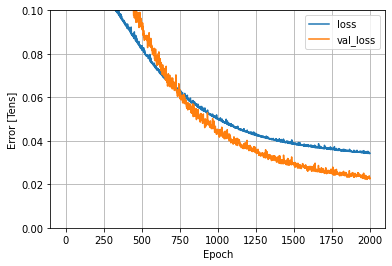

In [90]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=2000)

plot_loss(history)

In [91]:
test_predictions = dnn_model.predict(test_features).flatten()

mae = tf.keras.losses.MeanAbsoluteError()
print(mae(test_labels, test_predictions).numpy())

mape = tf.keras.losses.MeanAbsolutePercentageError()
print(mape(test_labels, test_predictions).numpy())

mse = tf.keras.losses.MeanSquaredError()
print(mse(test_labels, test_predictions).numpy())

metric = tfa.metrics.r_square.RSquare()
metric.update_state(test_labels, test_predictions)
result = metric.result()
print(result.numpy())

4/4 [==============================] - 0s 3ms/step
0.1528315
3.8964112
0.039299086
0.95170283
